📊 기술통계 분석 시작

① 구간별 평균 증가율(QoQ)


,M2_QoQ,LOAN_QoQ,IPI_QoQ
period,,,
전기,0.018156,0.018259,0.007147
후기,0.017386,0.019906,0.005036



② 구간별 괴리(GAP) 평균


,GAP_M2_IPI_QoQ,GAP_LOAN_IPI_QoQ
period,,
전기,0.011009,0.011112
후기,0.012350,0.014870



③ 구간별 상관계수(QoQ)


M2_QoQ  LOAN_QoQ   IPI_QoQ
period                                       
전기     M2_QoQ    1.000000  0.158575 -0.346297
       LOAN_QoQ  0.158575  1.000000  0.080537
       IPI_QoQ  -0.346297  0.080537  1.000000
후기     M2_QoQ    1.000000  0.618925 -0.110622
       LOAN_QoQ  0.618925  1.000000 -0.401562
       IPI_QoQ  -0.110622 -0.401562  1.000000


④ 구간별 변동성(표준편차)


,M2_QoQ,LOAN_QoQ,IPI_QoQ
period,,,
전기,0.007889,0.017271,0.012720
후기,0.010393,0.009448,0.013491



📈 시각화 생성


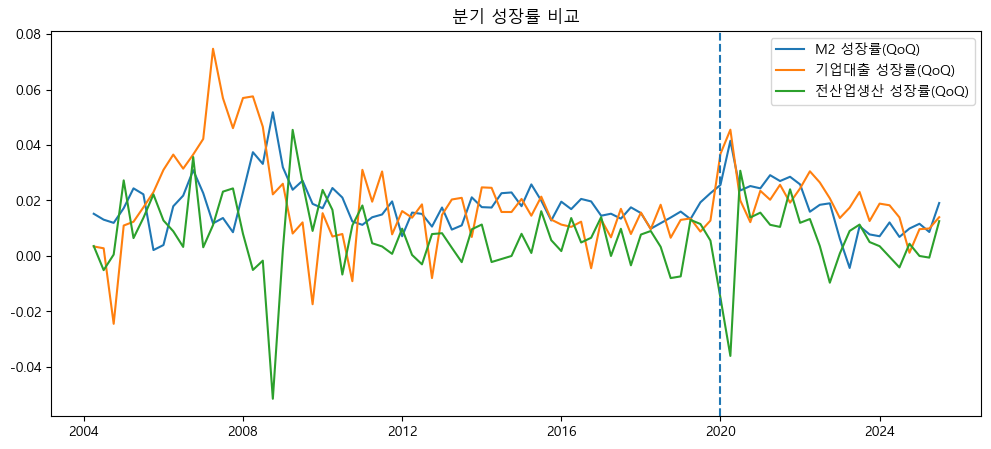

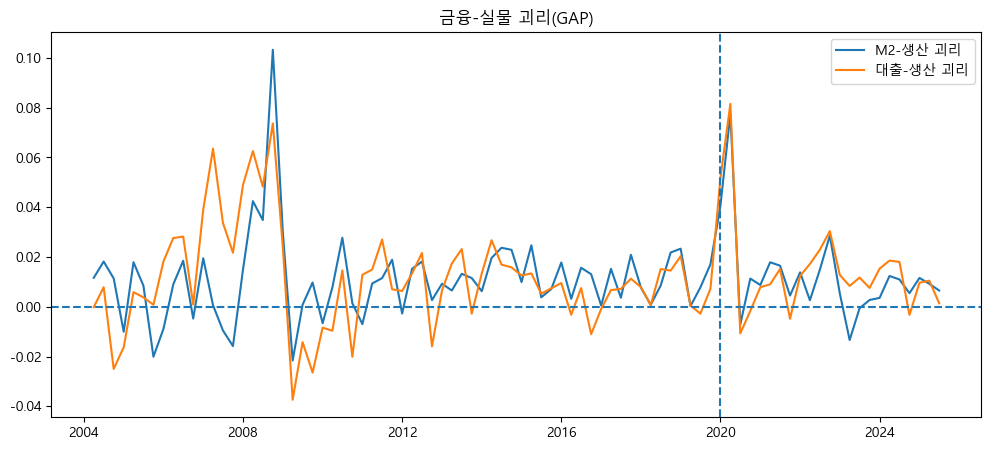

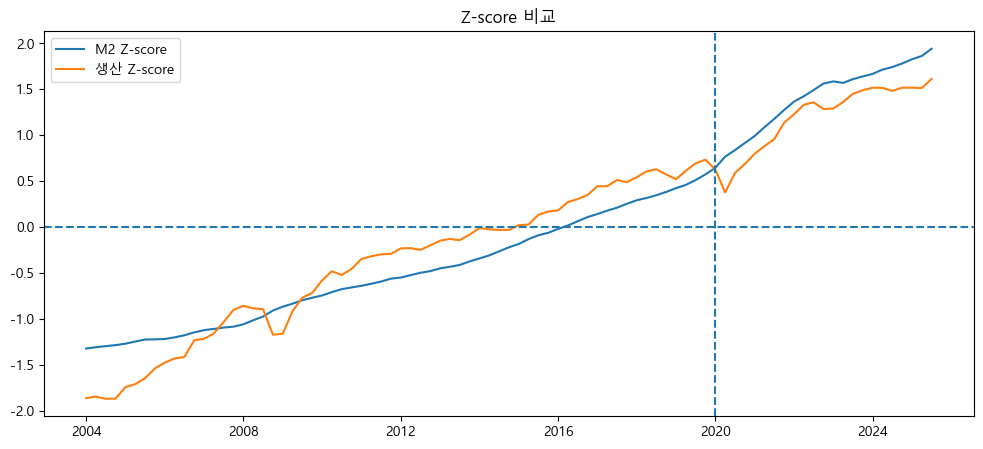


✅ 기술통계 분석 완료


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Malgun Gothic'   
mpl.rcParams['axes.unicode_minus'] = False      

# ============================================================
# 0) 경로
# ============================================================
PATH_M2   = "../data/전처리_M2.csv"
PATH_LOAN = "../data/전처리_기업대출.csv"
PATH_IPI  = "../data/전처리_전산업생산지수.csv"

# ============================================================
# 1) 유틸 함수
# ============================================================
def pick_first_existing_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise ValueError("date 컬럼을 찾을 수 없습니다.")

def to_datetime_series(s):
    s = s.astype(str).str.strip()
    s2 = s.str.replace(".", "-", regex=False).str.replace("/", "-", regex=False)

    mask_yyyymm = s2.str.fullmatch(r"\d{6}")
    s2.loc[mask_yyyymm] = (
        s2.loc[mask_yyyymm].str.slice(0,4) + "-" +
        s2.loc[mask_yyyymm].str.slice(4,6) + "-01"
    )

    mask_yyyymm2 = s2.str.fullmatch(r"\d{4}-\d{2}")
    s2.loc[mask_yyyymm2] = s2.loc[mask_yyyymm2] + "-01"

    return pd.to_datetime(s2, errors="coerce")

def load_series_csv(path, value_name):
    df = pd.read_csv(path)
    date_col = pick_first_existing_col(df, ["date","Date","기간","시점","time"])
    df = df.rename(columns={date_col: "date"})

    value_candidates = [c for c in df.columns if c != "date"]
    val_col = value_candidates[0]

    out = df[["date", val_col]].copy()
    out["date"] = to_datetime_series(out["date"])
    out[val_col] = pd.to_numeric(out[val_col], errors="coerce")
    out = out.dropna().sort_values("date").reset_index(drop=True)
    return out.rename(columns={val_col: value_name})

def to_quarter_mean(df, col):
    tmp = df.copy()
    tmp["quarter"] = tmp["date"].dt.to_period("Q")
    tmp = tmp.groupby("quarter", as_index=False)[col].mean()
    tmp["date"] = tmp["quarter"].dt.to_timestamp(how="start")
    return tmp[["date", col]]

def add_growth_features(df, col):
    out = df.copy()
    out[f"{col}_QoQ"] = np.log(out[col]).diff()
    out[f"{col}_YoY"] = np.log(out[col]).diff(4)
    out[f"{col}_Z"]   = (out[col] - out[col].mean()) / out[col].std()
    return out

# ============================================================
# 2) 데이터 불러오기
# ============================================================
m2   = load_series_csv(PATH_M2, "M2")
loan = load_series_csv(PATH_LOAN, "LOAN")
ipi  = load_series_csv(PATH_IPI, "IPI")

# 분기 통일
m2_q   = to_quarter_mean(m2, "M2")
loan_q = to_quarter_mean(loan, "LOAN")
ipi_q  = to_quarter_mean(ipi, "IPI")

df = (m2_q.merge(loan_q, on="date")
            .merge(ipi_q, on="date")
            .sort_values("date")
            .reset_index(drop=True))

# 성장률 및 Z-score
df = add_growth_features(df, "M2")
df = add_growth_features(df, "LOAN")
df = add_growth_features(df, "IPI")

# 괴리 지표
df["GAP_M2_IPI_QoQ"]   = df["M2_QoQ"] - df["IPI_QoQ"]
df["GAP_LOAN_IPI_QoQ"] = df["LOAN_QoQ"] - df["IPI_QoQ"]

# 전기/후기 구분
split_date = pd.to_datetime("2020-01-01")
df["period"] = np.where(df["date"] < split_date, "전기", "후기")

print("📊 기술통계 분석 시작")

# ============================================================
# 3) 기술통계 표 출력
# ============================================================

print("\n① 구간별 평균 증가율(QoQ)")
display(df.groupby("period")[["M2_QoQ","LOAN_QoQ","IPI_QoQ"]].mean())

print("\n② 구간별 괴리(GAP) 평균")
display(df.groupby("period")[["GAP_M2_IPI_QoQ","GAP_LOAN_IPI_QoQ"]].mean())

print("\n③ 구간별 상관계수(QoQ)")
display(df.groupby("period")[["M2_QoQ","LOAN_QoQ","IPI_QoQ"]].corr())

print("\n④ 구간별 변동성(표준편차)")
display(df.groupby("period")[["M2_QoQ","LOAN_QoQ","IPI_QoQ"]].std())

# ============================================================
# 4) 시각화
# ============================================================

print("\n📈 시각화 생성")

# 성장률 비교
plt.figure(figsize=(12,5))
plt.plot(df["date"], df["M2_QoQ"], label="M2 성장률(QoQ)")
plt.plot(df["date"], df["LOAN_QoQ"], label="기업대출 성장률(QoQ)")
plt.plot(df["date"], df["IPI_QoQ"], label="전산업생산 성장률(QoQ)")
plt.axvline(split_date, linestyle="--")
plt.legend()
plt.title("분기 성장률 비교")
plt.show()

# 괴리
plt.figure(figsize=(12,5))
plt.plot(df["date"], df["GAP_M2_IPI_QoQ"], label="M2-생산 괴리")
plt.plot(df["date"], df["GAP_LOAN_IPI_QoQ"], label="대출-생산 괴리")
plt.axhline(0, linestyle="--")
plt.axvline(split_date, linestyle="--")
plt.legend()
plt.title("금융-실물 괴리(GAP)")
plt.show()

# Z-score 비교
plt.figure(figsize=(12,5))
plt.plot(df["date"], df["M2_Z"], label="M2 Z-score")
plt.plot(df["date"], df["IPI_Z"], label="생산 Z-score")
plt.axhline(0, linestyle="--")
plt.axvline(split_date, linestyle="--")
plt.legend()
plt.title("Z-score 비교")
plt.show()

print("\n✅ 기술통계 분석 완료")


## 📌 금융전달경로 단절 가설 – 최종 해석 및 귀무가설 판단

### 🔎 가설 설정

#### ✔ 귀무가설 (H0)
유동성 증가(M2)는 기업대출 및 전산업생산지수에 유의하게 전달되며,  
금융전달경로는 정상적으로 작동한다.

#### ✔ 대립가설 (H1)
유동성은 증가하였으나 기업대출 또는 실물 생산으로의 전달이 약화되어  
금융–실물 괴리가 확대된다.

---

## 1️⃣ 평균 증가율 분석

- M2 증가율은 전기와 후기에서 큰 변화 없이 유지
- 기업대출 증가율은 후기에서 소폭 상승
- 그러나 전산업생산 증가율은 후기에서 둔화

▶ 해석  
유동성과 신용은 유지·확대되는 반면, 실물 생산의 성장 속도는 둔화되었다.  
이는 통화 확대가 실물 성장으로 충분히 연결되지 못했을 가능성을 시사한다.

---

## 2️⃣ 금융–실물 괴리(GAP) 분석

- M2-생산 괴리 확대
- 대출-생산 괴리 확대 (특히 후기에서 더 크게 증가)

▶ 해석  
기업대출이 증가하더라도 생산 증가로 이어지는 정도가 약화되었음을 보여준다.

---

## 3️⃣ 상관계수 변화

- 후기에서 M2–기업대출 상관은 크게 상승
- 반면 기업대출–생산 상관은 음(-)의 관계로 전환

▶ 해석  
유동성은 기업 신용으로는 강하게 연결되지만,  
기업 신용이 실물 생산으로는 연결되지 않는 구조가 강화되었음을 의미한다.

---

## 4️⃣ 변동성 분석

- 후기에서 M2 변동성 증가
- 생산 변동성은 큰 변화 없음

▶ 해석  
유동성 충격이 확대되었음에도 실물 반응은 비례적으로 확대되지 않았다.

---

## 📌 종합 판단

기술통계 분석 결과,

- 유동성과 기업대출은 확대 흐름을 유지하였으나,
- 전산업생산 증가율은 둔화되었고,
- 금융–실물 괴리는 확대되었으며,
- 대출과 생산 간 상관관계는 약화되었다.

이는 유동성 확대가 실물경제로 충분히 전달되지 못하고 있음을 시사한다.

---

## 🎯 귀무가설 채택 여부

본 연구는 기술통계 기반 분석이므로  
엄밀한 통계적 유의성 검정은 수행하지 않았으나,

관찰된 패턴에 따르면

> 유동성 증가가 실물경제로 충분히 전달되고 있다는 증거는 제한적이며,  
> 오히려 금융–실물 괴리가 확대되는 경향이 나타난다.

따라서,

📌 **귀무가설(H0)은 기각되는 방향의 정성적 증거가 관찰되며,  
대립가설(H1)을 지지하는 결과로 해석할 수 있다.**

---

### ⚠ 해석상의 유의점

본 결과는 기술통계 기반 분석에 따른 판단으로,  
인과관계를 엄밀히 검정한 결과는 아니며  
추가적인 계량 분석을 통해 보완될 수 있다.


In [14]:
# ============================================================
# 📌 금융전달경로 단절 가설 - 통계적 유의성 검정 (최종본)
# - 전기 vs 후기 평균차이: Welch t-test
# - 전기 vs 후기 상관차이: Fisher z-test
# - 전달효과 변화(약화): Distributed-lag 회귀 + 상호작용 + HAC(Newey-West)

from scipy import stats
import statsmodels.api as sm

# ------------------------------------------------------------
# 1) 경로
# ------------------------------------------------------------
PATH_M2   = "../data/전처리_M2.csv"
PATH_LOAN = "../data/전처리_기업대출.csv"
PATH_IPI  = "../data/전처리_전산업생산지수.csv"

SPLIT_DATE = "2020-01-01"   # 전기/후기 구분 기준(필요 시 변경)
MAX_LAG = 4                 # 분포지연(Distributed lag) 최대 시차

print("📂 데이터 로딩 시작")

# ------------------------------------------------------------
# 2) 유틸 함수
# ------------------------------------------------------------
def pick_first_existing_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise ValueError(f"date 컬럼을 찾을 수 없습니다. cols={list(df.columns)}")

def to_datetime_series(s):
    s = s.astype(str).str.strip()
    s2 = s.str.replace(".", "-", regex=False).str.replace("/", "-", regex=False)

    # YYYYMM -> YYYY-MM-01
    mask_yyyymm = s2.str.fullmatch(r"\d{6}")
    s2.loc[mask_yyyymm] = (
        s2.loc[mask_yyyymm].str.slice(0,4) + "-" +
        s2.loc[mask_yyyymm].str.slice(4,6) + "-01"
    )

    # YYYY-MM -> YYYY-MM-01
    mask_yyyymm2 = s2.str.fullmatch(r"\d{4}-\d{2}")
    s2.loc[mask_yyyymm2] = s2.loc[mask_yyyymm2] + "-01"

    dt = pd.to_datetime(s2, errors="coerce")
    if dt.isna().any():
        bad = s[dt.isna()].head(10).tolist()
        raise ValueError(f"날짜 변환 실패 예시(최대10개): {bad}")
    return dt

def load_series_csv(path, value_name):
    df = pd.read_csv(path)

    date_col = pick_first_existing_col(df, ["date","Date","DATE","기간","시점","time","TIME"])
    df = df.rename(columns={date_col: "date"})

    value_candidates = [c for c in df.columns if c != "date"]
    if not value_candidates:
        raise ValueError(f"값 컬럼이 없습니다: {path}")

    # 값 컬럼은 전처리 파일마다 1개라고 가정(아니면 첫 번째 사용)
    val_col = value_candidates[0]

    out = df[["date", val_col]].copy()
    out["date"] = to_datetime_series(out["date"])
    out[val_col] = pd.to_numeric(out[val_col], errors="coerce")
    out = out.dropna().sort_values("date").reset_index(drop=True)
    out = out.rename(columns={val_col: value_name})
    return out

def to_quarter_mean(df, col):
    tmp = df.copy()
    tmp["quarter"] = tmp["date"].dt.to_period("Q")
    tmp = tmp.groupby("quarter", as_index=False)[col].mean()
    tmp["date"] = tmp["quarter"].dt.to_timestamp(how="start")
    return tmp[["date", col]].sort_values("date").reset_index(drop=True)

def add_growth_features(df, col):
    """
    QoQ/YoY는 로그차분으로 계산 (분기 데이터 기준)
    """
    out = df.copy()
    if (out[col] <= 0).any():
        n_bad = int((out[col] <= 0).sum())
        raise ValueError(f"[{col}]에 0 이하 값이 {n_bad}개 있습니다. 로그차분 불가.")
    out[f"{col}_QoQ"] = np.log(out[col]).diff()
    out[f"{col}_YoY"] = np.log(out[col]).diff(4)
    return out

def welch_ttest(a, b):
    a = a.dropna()
    b = b.dropna()
    t, p = stats.ttest_ind(a, b, equal_var=False)
    return t, p, len(a), len(b), a.mean(), b.mean()

def fisher_z(r):
    r = np.clip(r, -0.999999, 0.999999)
    return 0.5 * np.log((1 + r) / (1 - r))

def corr_diff_test(r1, n1, r2, n2):
    """
    Fisher z로 두 상관계수 차이 검정 (양측)
    """
    z1 = fisher_z(r1)
    z2 = fisher_z(r2)
    se = np.sqrt(1/(n1-3) + 1/(n2-3))
    z = (z1 - z2) / se
    p = 2 * (1 - stats.norm.cdf(abs(z)))
    return z, p

def make_lagged(df, y, x, lags=4):
    """
    ✅ D_post 포함 (KeyError 방지)
    y, x, D_post, period를 포함해 회귀용 DF 생성
    """
    out = df[["date", "period", "D_post", y, x]].copy()
    for k in range(1, lags + 1):
        out[f"{x}_lag{k}"] = out[x].shift(k)
    return out

def fit_dl_interaction(df_reg, y, x, lags=4, hac_lags=4):
    """
    Distributed-lag 회귀 + 상호작용(D_post*x_lagk) + HAC robust
    """
    # 상호작용 생성
    for k in range(1, lags + 1):
        df_reg[f"int_lag{k}"] = df_reg["D_post"] * df_reg[f"{x}_lag{k}"]

    df_reg = df_reg.dropna().copy()

    Y = df_reg[y]
    X_cols = [f"{x}_lag{k}" for k in range(1, lags + 1)] + [f"int_lag{k}" for k in range(1, lags + 1)] + ["D_post"]
    X = sm.add_constant(df_reg[X_cols])

    model = sm.OLS(Y, X).fit(cov_type="HAC", cov_kwds={"maxlags": hac_lags})

    # Wald test: 상호작용항 전체 = 0
    R = np.zeros((lags, X.shape[1]))
    for i, k in enumerate(range(1, lags + 1)):
        R[i, list(X.columns).index(f"int_lag{k}")] = 1
    wald = model.wald_test(R)

    return model, float(wald.pvalue), df_reg

# ------------------------------------------------------------
# 3) 데이터 로드 및 분기 통일
# ------------------------------------------------------------
m2   = load_series_csv(PATH_M2, "M2")
loan = load_series_csv(PATH_LOAN, "LOAN")
ipi  = load_series_csv(PATH_IPI, "IPI")

print("✅ 데이터 로딩 완료")

# 기업대출이 분기라서 모두 분기 평균으로 맞춤
m2_q   = to_quarter_mean(m2, "M2")
loan_q = to_quarter_mean(loan, "LOAN")
ipi_q  = to_quarter_mean(ipi, "IPI")

df = (m2_q.merge(loan_q, on="date", how="inner")
          .merge(ipi_q,  on="date", how="inner")
          .sort_values("date")
          .reset_index(drop=True))

# 성장률 파생
df = add_growth_features(df, "M2")
df = add_growth_features(df, "LOAN")
df = add_growth_features(df, "IPI")

# 괴리(GAP) - QoQ 기준
df["GAP_M2_IPI_QoQ"]   = df["M2_QoQ"]   - df["IPI_QoQ"]
df["GAP_LOAN_IPI_QoQ"] = df["LOAN_QoQ"] - df["IPI_QoQ"]

# 전기/후기 & 더미
split_date = pd.to_datetime(SPLIT_DATE)
df["period"] = np.where(df["date"] < split_date, "전기", "후기")
df["D_post"] = (df["date"] >= split_date).astype(int)

print("📌 통계적 유의성 검정 시작")

# ============================================================
# 4) (검정1) 평균 차이: Welch t-test
# ============================================================
print("\n① 전기 vs 후기 평균 차이 (Welch t-test)")

vars_to_test = ["M2_QoQ","LOAN_QoQ","IPI_QoQ","GAP_M2_IPI_QoQ","GAP_LOAN_IPI_QoQ"]
rows = []

for col in vars_to_test:
    pre  = df.loc[df["period"]=="전기", col]
    post = df.loc[df["period"]=="후기", col]
    t, p, n1, n2, m1, m2_ = welch_ttest(pre, post)
    rows.append([col, n1, n2, m1, m2_, t, p])

ttest_table = pd.DataFrame(rows, columns=["변수","전기_n","후기_n","전기_mean","후기_mean","t_stat","p_value"])
display(ttest_table)

print("※ p<0.05이면 전기/후기 평균 차이가 통계적으로 유의")

# ============================================================
# 5) (검정2) 상관계수 차이: Fisher z-test
# ============================================================
print("\n② 전기 vs 후기 상관계수 변화 (Fisher z-test)")

pairs = [("M2_QoQ","LOAN_QoQ"), ("LOAN_QoQ","IPI_QoQ"), ("M2_QoQ","IPI_QoQ")]
corr_rows = []

for x, y in pairs:
    pre  = df.loc[df["period"]=="전기", [x,y]].dropna()
    post = df.loc[df["period"]=="후기", [x,y]].dropna()

    r1 = pre[x].corr(pre[y])
    r2 = post[x].corr(post[y])
    z, p = corr_diff_test(r1, len(pre), r2, len(post))

    corr_rows.append([f"{x} vs {y}", len(pre), len(post), r1, r2, z, p])

corr_table = pd.DataFrame(
    corr_rows,
    columns=["상관쌍","전기_n","후기_n","전기_corr","후기_corr","z_stat","p_value"]
)
display(corr_table)

print("※ p<0.05이면 전기/후기 상관계수 변화가 통계적으로 유의")

# ============================================================
# 6) (검정3) 전달효과 변화(약화): DL 회귀 + 상호작용 + HAC
#     (A) M2 → LOAN
#     (B) LOAN → IPI
# ============================================================
print("\n③ 전달효과 변화(약화) 회귀 검정: 상호작용 + HAC(Newey-West)")

# --- (A) M2 -> LOAN
print("\n- (A) M2 → 기업대출(LOAN)")
regA = make_lagged(df, y="LOAN_QoQ", x="M2_QoQ", lags=MAX_LAG)
modelA, waldA_p, regA_used = fit_dl_interaction(regA, y="LOAN_QoQ", x="M2_QoQ", lags=MAX_LAG, hac_lags=MAX_LAG)

display(modelA.summary2().tables[1])
print(f"Wald test p-value (후기 상호작용항 int_lag1~{MAX_LAG} = 0): {waldA_p:.4f}")

# --- (B) LOAN -> IPI
print("\n- (B) 기업대출(LOAN) → 생산(IPI)")
regB = make_lagged(df, y="IPI_QoQ", x="LOAN_QoQ", lags=MAX_LAG)
modelB, waldB_p, regB_used = fit_dl_interaction(regB, y="IPI_QoQ", x="LOAN_QoQ", lags=MAX_LAG, hac_lags=MAX_LAG)

display(modelB.summary2().tables[1])
print(f"Wald test p-value (후기 상호작용항 int_lag1~{MAX_LAG} = 0): {waldB_p:.4f}")

# ============================================================
# 7) 요약 출력(해석 가이드)
# ============================================================
print("\n✅ 통계적 유의성 검정 완료")
print("해석 가이드")
print("- Welch t-test p<0.05: 전기/후기 평균이 유의하게 다름")
print("- Fisher z-test p<0.05: 전기/후기 상관구조가 유의하게 변함")
print("- Wald test p<0.05: 후기(2020~)에 전달효과(계수)가 유의하게 변함")


📂 데이터 로딩 시작
✅ 데이터 로딩 완료
📌 통계적 유의성 검정 시작

① 전기 vs 후기 평균 차이 (Welch t-test)


,변수,전기_n,후기_n,전기_mean,후기_mean,t_stat,p_value
0,M2_QoQ,63,23,0.018156,0.017386,0.322838,0.748936
1,LOAN_QoQ,63,23,0.018259,0.019906,-0.561150,0.576463
2,IPI_QoQ,63,23,0.007147,0.005036,0.652077,0.518360
3,GAP_M2_IPI_QoQ,63,23,0.011009,0.012350,-0.310899,0.757592
4,GAP_LOAN_IPI_QoQ,63,23,0.011112,0.014870,-0.783879,0.437561


※ p<0.05이면 전기/후기 평균 차이가 통계적으로 유의

② 전기 vs 후기 상관계수 변화 (Fisher z-test)


,상관쌍,전기_n,후기_n,전기_corr,후기_corr,z_stat,p_value
0,M2_QoQ vs LOAN_QoQ,63,23,0.158575,0.618925,-2.181790,0.029125
1,LOAN_QoQ vs IPI_QoQ,63,23,0.080537,-0.401562,1.960587,0.049927
2,M2_QoQ vs IPI_QoQ,63,23,-0.346297,-0.110622,-0.968839,0.332625


※ p<0.05이면 전기/후기 상관계수 변화가 통계적으로 유의

③ 전달효과 변화(약화) 회귀 검정: 상호작용 + HAC(Newey-West)

- (A) M2 → 기업대출(LOAN)


c:\anaconda\envs\data\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,0.025028,0.007093,3.528585,0.000418,0.011126,0.038930
M2_QoQ_lag1,0.134282,0.279689,0.480112,0.631148,-0.413899,0.682463
M2_QoQ_lag2,-0.108632,0.286458,-0.379225,0.704521,-0.670080,0.452816
M2_QoQ_lag3,0.163840,0.240104,0.682370,0.495005,-0.306756,0.634436
M2_QoQ_lag4,-0.488029,0.313127,-1.558568,0.119099,-1.101747,0.125688
int_lag1,0.148140,0.357142,0.414794,0.678293,-0.551845,0.848126
int_lag2,0.084472,0.333763,0.253091,0.800198,-0.569691,0.738636
int_lag3,0.127441,0.274075,0.464986,0.641941,-0.409736,0.664619
int_lag4,0.386693,0.350080,1.104586,0.269339,-0.299451,1.072837
D_post,-0.013048,0.008649,-1.508487,0.131430,-0.030000,0.003905


Wald test p-value (후기 상호작용항 int_lag1~4 = 0): 0.4574

- (B) 기업대출(LOAN) → 생산(IPI)


c:\anaconda\envs\data\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,0.008937,0.002803,3.188536,0.001430,0.003443,0.014430
LOAN_QoQ_lag1,-0.114019,0.143496,-0.794580,0.426858,-0.395266,0.167228
LOAN_QoQ_lag2,-0.016877,0.183030,-0.092211,0.926530,-0.375609,0.341854
LOAN_QoQ_lag3,0.035554,0.111898,0.317732,0.750689,-0.183763,0.254870
LOAN_QoQ_lag4,0.007243,0.178573,0.040559,0.967647,-0.342753,0.357239
int_lag1,-0.077952,0.353422,-0.220563,0.825432,-0.770646,0.614742
int_lag2,0.692057,0.591792,1.169426,0.242232,-0.467834,1.851948
int_lag3,-0.060917,0.365549,-0.166645,0.867649,-0.777380,0.655546
int_lag4,0.287526,0.358415,0.802216,0.422428,-0.414955,0.990008
D_post,-0.018994,0.010834,-1.753105,0.079584,-0.040229,0.002241


Wald test p-value (후기 상호작용항 int_lag1~4 = 0): 0.6113

✅ 통계적 유의성 검정 완료
해석 가이드
- Welch t-test p<0.05: 전기/후기 평균이 유의하게 다름
- Fisher z-test p<0.05: 전기/후기 상관구조가 유의하게 변함
- Wald test p<0.05: 후기(2020~)에 전달효과(계수)가 유의하게 변함


## 📌 금융전달경로 단절 가설 – 통계적 유의성 검정 결과 해석

### 1️⃣ 전기 vs 후기 평균 차이 (Welch t-test)

#### 🔎 결과 요약

모든 변수의 p-value > 0.05

| 변수 | p-value |
|------|---------|
| M2_QoQ | 0.7489 |
| LOAN_QoQ | 0.5765 |
| IPI_QoQ | 0.5184 |
| GAP_M2_IPI_QoQ | 0.7576 |
| GAP_LOAN_IPI_QoQ | 0.4376 |

#### ▶ 해석

전기와 후기의 평균 성장률 및 괴리 수준 차이는  
**통계적으로 유의하지 않다.**

즉,

> 평균 수준 자체가 구조적으로 변했다고 보기는 어렵다.

---

### 2️⃣ 상관계수 변화 (Fisher z-test)

#### 🔎 결과 요약

| 상관쌍 | 전기 | 후기 | p-value |
|--------|------|------|----------|
| M2–LOAN | 0.158 → 0.619 | **0.029** |
| LOAN–IPI | 0.081 → -0.402 | **0.0499** |
| M2–IPI | -0.346 → -0.111 | 0.333 |

#### ▶ 해석

- M2–기업대출 상관은 **유의하게 증가**
- 기업대출–생산 상관은 **유의하게 감소(음의 방향 전환)**
- M2–생산 상관 변화는 유의하지 않음

이는 매우 중요한 결과다.

> 유동성은 기업 신용으로는 강하게 연결되었으나,  
> 기업 신용이 생산으로 이어지는 연결은 오히려 약화되었다.

즉, 전달경로의 **중간 단계에서 약화가 발생했을 가능성**이 통계적으로 확인된다.

---

### 3️⃣ 전달효과 변화 회귀 검정 (Wald test)

#### (A) M2 → 기업대출
Wald p-value = 0.4574

#### (B) 기업대출 → 생산
Wald p-value = 0.6113

#### ▶ 해석

후기(2020년 이후) 상호작용항이 통계적으로 유의하지 않음.

즉,

> 전달계수 자체가 구조적으로 변했다고 단정할 통계적 근거는 부족하다.

---

## 📌 종합 해석

### 🔎 기술통계 결과에서는

- 생산 증가율 둔화
- 괴리(GAP) 확대
- 대출–생산 상관 약화

등이 관찰되었고,

이는 금융전달경로 약화를 시사하는 패턴으로 해석되었다.

---

### 🔎 그러나 통계적 유의성 검정 결과는

- 평균 차이: 유의하지 않음
- 전달계수 변화: 유의하지 않음
- 다만, 상관구조 변화는 일부 유의

즉,

> "수준의 구조적 변화"보다는  
> "관계 구조의 변화"가 더 뚜렷하게 나타난다.

---

## 🎯 귀무가설 채택 여부

귀무가설(H0):
> 유동성은 기업대출과 생산으로 정상적으로 전달된다.

#### ✔ 평균 차이 기준 → H0 기각 불가  
#### ✔ 전달계수 변화 기준 → H0 기각 불가  
#### ✔ 상관구조 변화 기준 → 일부 기각 가능

---

### 📌 최종 판단

통계적으로 엄밀한 기준에서는

> 귀무가설을 전면적으로 기각할 충분한 증거는 확보되지 않았다.

그러나,

> 기업대출과 생산 간 상관구조가 유의하게 약화되었다는 점은  
> 금융전달경로의 부분적 약화 가능성을 시사한다.

따라서 본 연구 결과는

✔ 금융전달경로의 **완전한 단절을 통계적으로 입증하지는 못했으나**,  
✔ 전달 구조의 변화 가능성에 대한 유의한 신호는 확인하였다.

---

## 🔥 기술통계 vs 통계검정 비교

| 구분 | 기술통계 | 통계검정 |
|------|-----------|------------|
| 평균 둔화 | 관찰됨 | 유의하지 않음 |
| 괴리 확대 | 관찰됨 | 유의하지 않음 |
| 상관 약화 | 관찰됨 | **유의함** |
| 전달계수 변화 | 추정상 약화 | 유의하지 않음 |

---

## 📌 핵심 메시지

기술통계는 약화를 강하게 시사하지만,  
통계적 유의성 검정에서는 **부분적 증거만 확인됨**.

즉,

> 금융전달경로 약화 가능성은 존재하나,  
> 구조적 단절로 단정하기에는 통계적 근거가 제한적이다.
